# Time Series Subsequence Clustering

## Signal Processing Exploration

In [3]:
import numpy as np
import scipy
from scipy import ndimage
from scipy.spatial.distance import euclidean,pdist, squareform, cdist
import matplotlib.pyplot as plt

x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.8
c = np.sin(x)
diff = y-c
print("D(x_s, c_n)", np.sum(diff))

plt.plot(x, y,'o')
plt.plot(x, c, 'g-', lw=2)
plt.plot(x, diff, 'r-', lw=2)

y_gauss = scipy.ndimage.filters.gaussian_filter1d(diff, 3.0, axis=-1, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
plt.plot(x, y_gauss, 'b-', lw=2)

print("Gaus(D(x_s, c_n))", np.sum(y_gauss))



D(x_s, c_n) 34.8398576569
Gaus(D(x_s, c_n)) 34.8398576569


## Time Series Clustering
Working through examples from http://alexminnaar.com/time-series-classification-and-clustering-with-python.html

In [20]:
import numpy as np
import scipy
from scipy import ndimage
from scipy.spatial.distance import euclidean,pdist, squareform, cdist
import matplotlib.pyplot as plt

# Similarity Matrix
def EuclideanDistance(t1, t2):
    return np.sqrt(np.sum((t1-t2)**2))

# Dynamic Time Warping
def DTWDistance(s1, s2):
    # Initialize distance matrix (nxn), pad filling with inf  
    DTW= {}
    n1 = range(len(s1))
    n2 = range(len(s2))
    for i in n1:
        DTW[(i, -1)] = float('inf')
    for i in n2:
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0
    
    # Compute the distances (O(nm) time)
    for i in n1:
        for j in n2:
            dist = (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)], DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])


euclid 9.091869485041544
dtw 4.652305750981295


Testing difference between euclideean and dtw distance metrics.

In [84]:
x = np.linspace(0,2*np.pi,100)

s1 = np.sin(x)# + np.random.random(100) * 0.8
s2 = np.sin(x+5) 


plt.plot(x, s1, 'r')
plt.plot(x, s2, 'b')
plt.title("Comparing Tranformed Signal w/ Difference Distance Metrics")



Text(0.5,1,'Comparing Tranformed Signal w/ Difference Distance Metrics')

In [40]:
%timeit EuclideanDistance(s1, s2)
print "euclid", EuclideanDistance(s1, s2)

The slowest run took 8.98 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 4.42 µs per loop
euclid 8.475669849851327


In [103]:
# %timeit DTWDistance(s1, s2)
print "dtw", DTWDistance(s1, s2)

dtw 3.717113297468906


In [54]:
# Fast DTW (locality constraint)
def FastDTWDistance(s1, s2, w):
    w = max(w, abs(len(s1) - len(s2)))
    # Initialize distance matrix (nxn), pad filling with inf  
    DTW= {}
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
    
    # Compute the distances (O(nm) time)
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist = (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)], DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])


A locality constraint can be used to speed of DTW. In this run, elements that are further than a third of the window size (w/3) are not considered.  

In [58]:
%timeit FastDTWDistance(s1, s2, len(s1)/3)
print "fast_dtw", FastDTWDistance(s1, s2, len(s1)/3)

100 loops, best of 3: 8.89 ms per loop
fast_dtw 3.7171132974689063


![LB_Keogh](files/images/LB_Keogh.GIF)

In [63]:
#Lower Bound Keogh (LB Keough)
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):

        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])

        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2

    return np.sqrt(LB_sum)

In [79]:
print "LB_Keogh", LB_Keogh(s1, s2, 5)

LB_Keogh 6.521118234982505


In [76]:
from fastdtw import fastdtw

%timeit fastdtw(s1, s2, dist=euclidean)
distance, path = fastdtw(s1, s2, dist=euclidean)
print "FastDTW", distance

10 loops, best of 3: 27.6 ms per loop
FastDTW 21.4784064195


In [81]:
from dtw import dtw
%timeit dtw(s1, s2, dist=euclidean)
distance, cost, acc, path = dtw(s1, s2, dist=euclidean)
print "DTW", distance

10 loops, best of 3: 133 ms per loop
DTW 0.1050531557389213


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


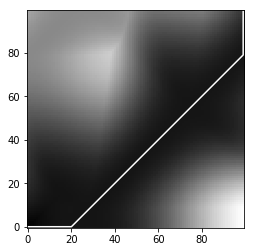

In [97]:
%pylab
%matplotlib inline 
imshow(acc.T, origin='lower', cmap=cm.gray, interpolation="nearest")
plot(path[0], path[1], 'w')
xlim((-0.5, acc.shape[0]-0.5))
ylim((-0.5, acc.shape[1]-0.5))
plt.show()

In [89]:
x = array([0, 0, 1, 1, 2, 4, 2, 1, 2, 0]).reshape(-1, 1)
y = array([1, 1, 1, 2, 2, 2, 2, 3, 2, 0]).reshape(-1, 1)


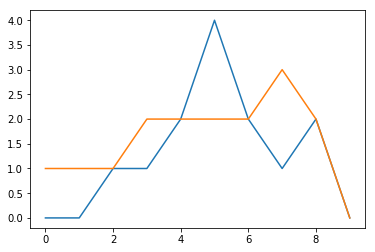

In [98]:
plt.plot(x)
plt.plot(y)

distance 0.2
euclidean 3.3166247903554
dtw [2.]
fast_dtw [2.]


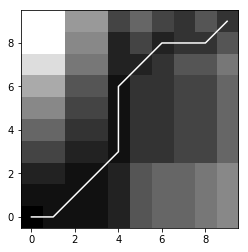

In [108]:
distance, cost, acc, path = dtw(x, y, dist=euclidean)
print "distance", distance
print "euclidean", EuclideanDistance(x, y)
print "dtw", DTWDistance(x, y)
print "fast_dtw", FastDTWDistance(x, y, len(x)/3)
imshow(acc.T, origin='lower', cmap=cm.gray, interpolation="nearest")
plot(path[0], path[1], 'w')
xlim((-0.5, acc.shape[0]-0.5))
ylim((-0.5, acc.shape[1]-0.5))
plt.show()

NameError: name 'path_cost' is not defined

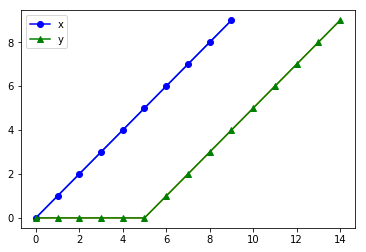

In [110]:
x = range(10)
y = [0] * 5 + x

x = array(x).reshape(-1, 1)
y = array(y).reshape(-1, 1)
plot(x)
plot(y)
plt.plot(x, 'bo-' ,label='x')
plt.plot(y, 'g^-', label = 'y')
plt.legend();
paths = path_cost(x, y, accumulated_cost, distances)[0]
for [map_x, map_y] in paths:
    #print map_x, x[map_x], ":", map_y, y[map_y]
    
    plt.plot([map_x, map_y], [x[map_x], y[map_y]], 'r')